**Universidade Federal de Pernambuco - Centro de Informática**  
**Especialização em Ciência de Dados**  
**Disciplina:** Análise de Séries Temporais  
**Docente:** Paulo Salgado Gomes de Mattos Neto  
**Discente:** Eduardo Henrique Ximenes de Melo e Menezes

# Bibliotecas fundamentais

In [90]:
# Executar esse código apenas se não tiver pmdarima instalado previamente.
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as split_ML
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import pmdarima as pm
from pmdarima import utils
from pmdarima.arima import arima
from pmdarima.model_selection import train_test_split as split_ARIMA

import warnings
warnings.filterwarnings("ignore")

# Sobre a série temporal

A série escolhida foi vendas_varejo_pe, disponível no [Github do usuário Eraylson](https://github.com/Eraylson/series_temporais). Ela consiste em vendas mensais do varejo de Pernambuco de 2000 a 2015.

In [92]:
uri = 'https://raw.githubusercontent.com/Eraylson/series_temporais/master/vendas_varejo_pe.csv'
varejo = pd.read_csv(uri, sep=';', index_col=0)

varejo = varejo.applymap(lambda x: str(x.replace(',','.')))
varejo.Venda = varejo.Venda.astype(float)
varejo.head()

,Venda
data,
jan/00,56.0
fev/00,54.4
mar/00,53.6
abr/00,53.5
mai/00,57.1


In [93]:
varejo.shape[0]

189

É importante ilustrar a série com um gráfico para se obter uma visão geral.

<Axes: xlabel='data'>

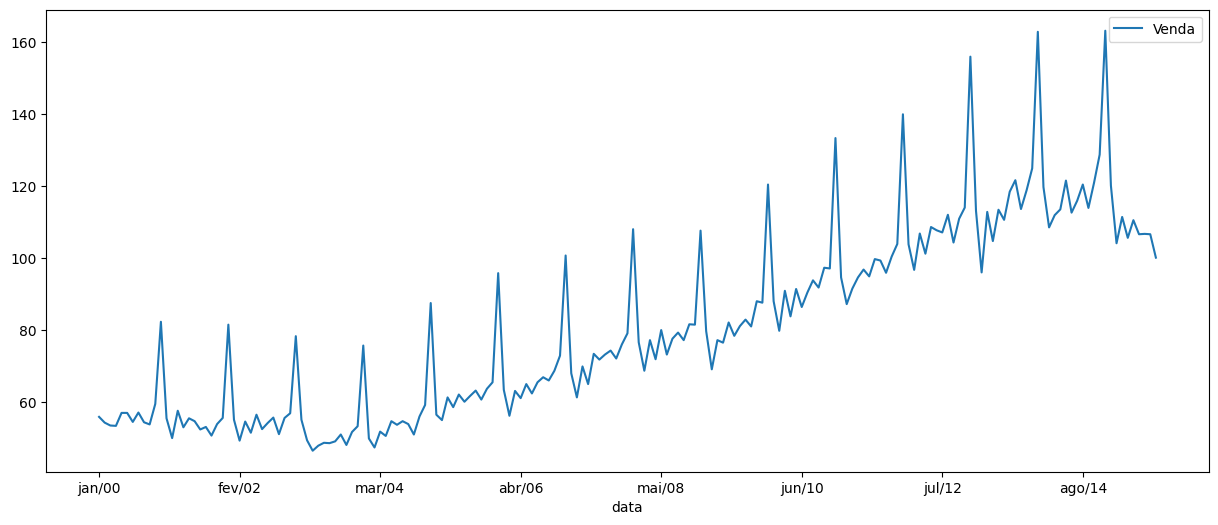

In [94]:
varejo.plot()

Nota-se uma possível tendência e um efeito sazonal claro. A série dificilmente passará no teste de estacionariedade. Pode-se ver mais detalhes com uma decomposição da série temporal.

Text(0.5, 1.0, 'Vendas do varejo de Pernambuco')

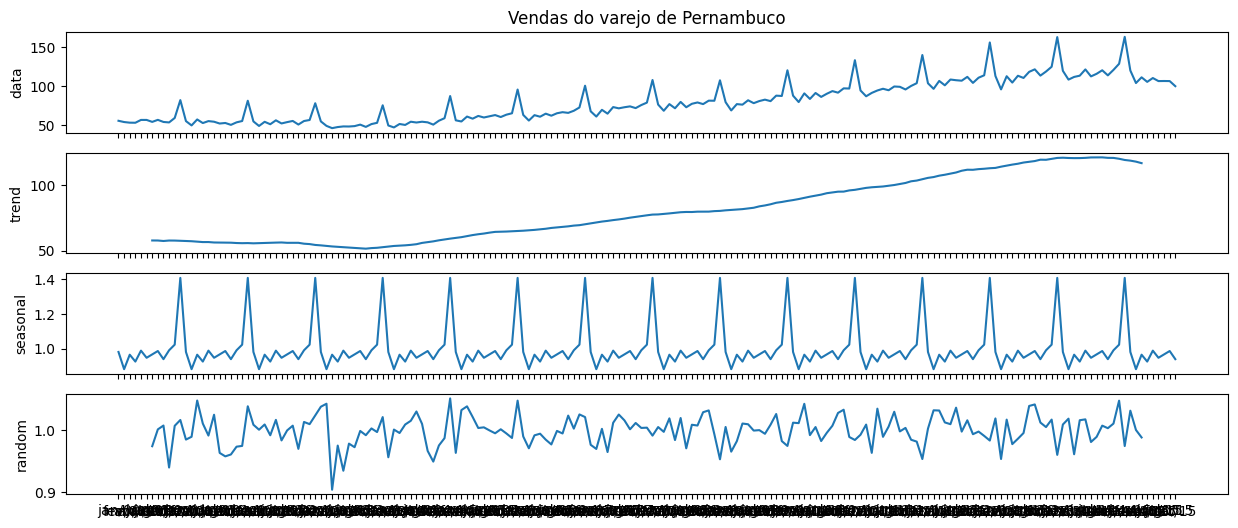

In [95]:
decomposed_varejo = pm.arima.decompose(varejo.Venda, 'multiplicative', m=12)

axes_varejo = utils.decomposed_plot(decomposed_varejo, figure_kwargs={'figsize': (15, 6)}, show=False)

axes_varejo[0].set_title("Vendas do varejo de Pernambuco")

Como a série aparenta ter uma sazonalidade anual, é prudente observar sua autocorrelação e autocorrelação parcial com dois anos de lags, ou 24 meses.

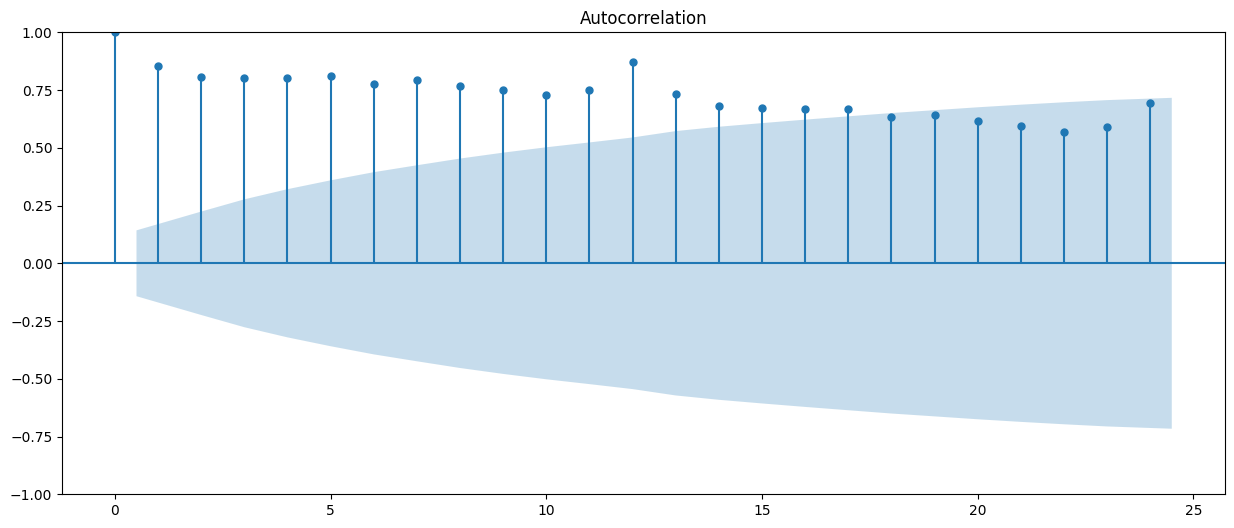

In [96]:
plot_acf(varejo, lags=24)
plt.show()

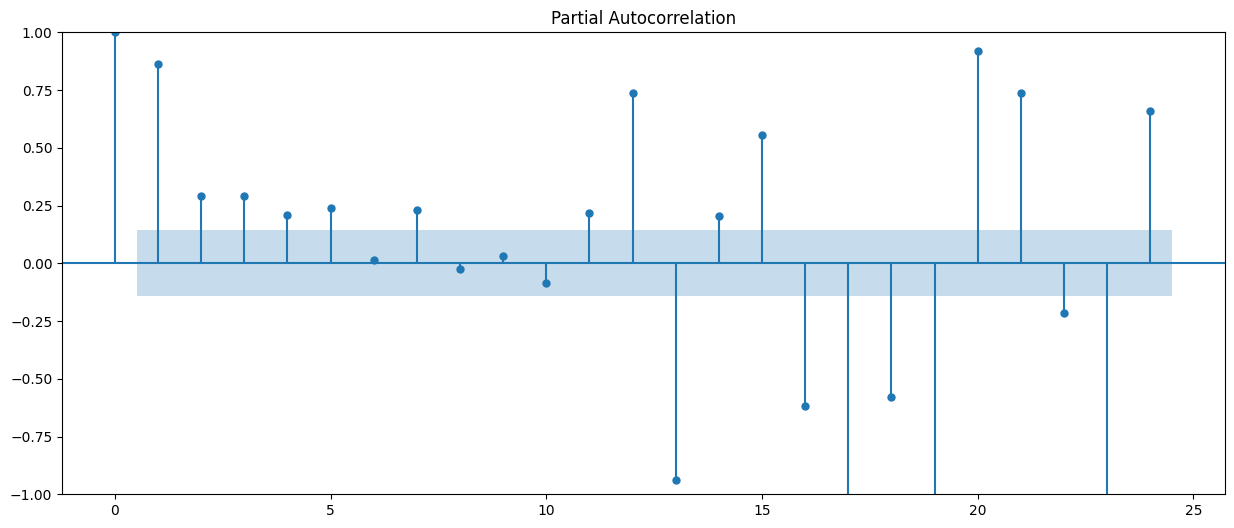

In [97]:
plot_pacf(varejo, lags=24)
plt.show()

Na hora de desenvolver os modelos, será necessário trabalhar com dados normalizados. Por isso, será criada antecipadamente uma coluna com os dados transformados com MinMaxScaler.

In [98]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(varejo.Venda.values.reshape(-1, 1))
varejo['Venda_norm'] = min_max_scaler.transform(varejo.Venda.values.reshape(-1, 1)).flatten()
varejo.head()

,Venda,Venda_norm
data,,
jan/00,56.0,0.080617
fev/00,54.4,0.066895
mar/00,53.6,0.060034
abr/00,53.5,0.059177
mai/00,57.1,0.090051


# Modelo Estatístico Linear

## Teste de estacionariedade

O modelo estatístico requer uma série estacionária. Caso a série não seja assim, será necessário realizar uma diferenciação e observar a sua estacionariedade até uma série estacionária ser obtida. Para ser possível afirmar com segurança acerca da estacionariedade, será realizado um teste ADF.

In [99]:
def testar_estacionariedade(df_test):
  stationary_test = adfuller(df_test)
  print('Estatística ADF:', stationary_test[0])
  print('p-valor:', stationary_test[1])
  print('Valores críticos:')
  for key, value in stationary_test[4].items():
    print('\t%s: %.3f' % (key, value))
  if stationary_test[1] <= 0.05:
    print('Os dados são estacionários.')
  else:
    print('Os dados são não-estacionários.')

In [100]:
testar_estacionariedade(varejo.Venda)

Estatística ADF: -1.7095058233789606
p-valor: 0.4262215657872478
Valores críticos:
	1%: -3.469
	5%: -2.878
	10%: -2.576
Os dados são não-estacionários.


Como a série não é estacionária, ela será testada até três diferenciações, e as que possuir menor p-valor terá suas autocorrelações normal e parcial observadas para o método estatístico.

In [101]:
testar_estacionariedade(varejo.diff().dropna().Venda)

Estatística ADF: -1.013086622690531
p-valor: 0.748461381389133
Valores críticos:
	1%: -3.469
	5%: -2.878
	10%: -2.576
Os dados são não-estacionários.


In [102]:
testar_estacionariedade(varejo.diff().diff().dropna().Venda)

Estatística ADF: -13.186565536687803
p-valor: 1.1669090930956057e-24
Valores críticos:
	1%: -3.469
	5%: -2.878
	10%: -2.576
Os dados são estacionários.


In [103]:
testar_estacionariedade(varejo.diff().diff().diff().dropna().Venda)

Estatística ADF: -11.752599765782826
p-valor: 1.1992608497230532e-21
Valores críticos:
	1%: -3.469
	5%: -2.879
	10%: -2.576
Os dados são estacionários.


Duas diferenciações se mostraram suficientes para tornar os dados estacionários e ainda alcançar um menor p-valor. Para fins de comparação, a série com duas diferenciações será salva como varejo_diff. Agora é necessário observar as autocorrelações normal e parcial.

## Análise de parâmetros ARIMA

In [104]:
varejo_diff = varejo.diff().diff().dropna()

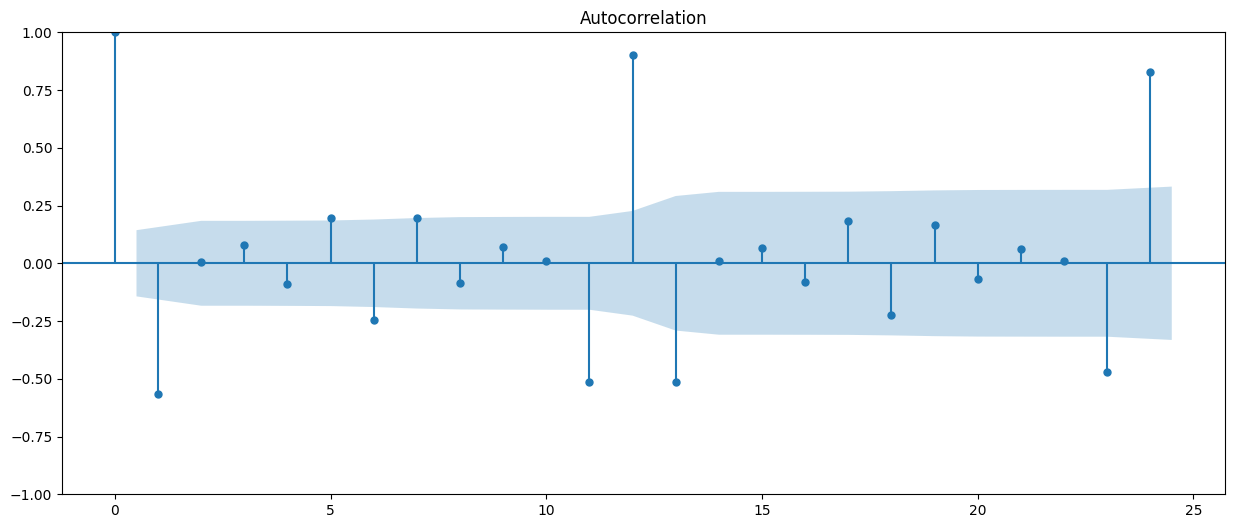

In [105]:
plot_acf(varejo_diff.Venda, lags=24)
plt.show()

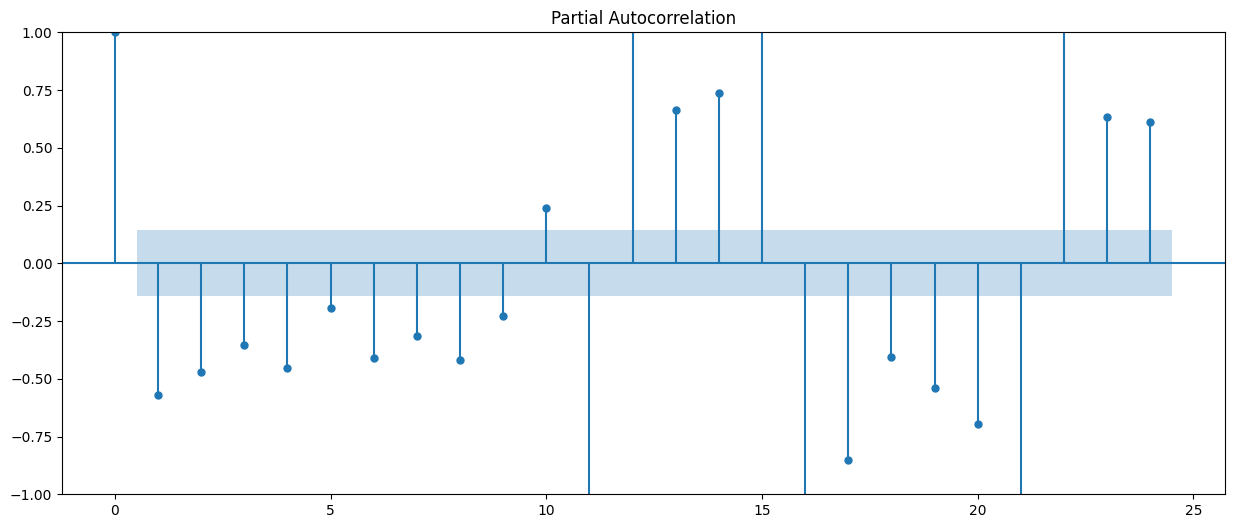

In [106]:
plot_pacf(varejo_diff.Venda, lags=24)
plt.show()

Observando-se os gráficos, percebe-se que os parâmetros do ARIMA serão 1 para AR, 1 para MA, e 2 para o ARIMA. 12 no AR e no MA sugere resultados com correlação positiva e de magnitude maior, mas não é prudente ignorar um modelo mais parcimonioso.  
A seguir, serão desenvolvidos um modelo ARMA com a série diferenciada e um ARIMA com a série original.

## Conjuntos de treino e teste

A série será dividida em treino e teste na proporção 3:1. Como são 189 elementos, o treino será realizado com 141 elementos, e o teste com 48. Os modelos, tanto estatístico como de aprendizado de máquina, vão trabalhar com a série normalizada, então o conjunto y não precisa dos dados originais.

In [107]:
y_varejo = varejo.Venda_norm.copy()
train_len_varejo = len(y_varejo) - 48

y_train_varejo_ARIMA = y_varejo[:train_len_varejo]
y_test_varejo_ARIMA = y_varejo[train_len_varejo:]
print("Elementos de treino:", len(y_train_varejo_ARIMA))
print("Elementos de teste:", len(y_test_varejo_ARIMA))

Elementos de treino: 141
Elementos de teste: 48


Como houve exclusão de valores na diferenciação, será importante recalibrar a normalização do conjunto diferenciado.

In [108]:
y_varejo_diff = varejo_diff.copy()
train_len_varejo_diff = len(y_varejo_diff) - 48

min_max_scaler_diff = MinMaxScaler(feature_range=(0,1))
min_max_scaler_diff.fit(y_varejo_diff.Venda[0:train_len_varejo_diff].values.reshape(-1, 1))
y_varejo_diff.Venda_norm = min_max_scaler_diff.transform(y_varejo_diff.Venda.values.reshape(-1, 1)).flatten()

y_train_varejo_ARIMA_diff = y_varejo_diff.Venda_norm[:train_len_varejo_diff]
y_test_varejo_ARIMA_diff = y_varejo_diff.Venda_norm[train_len_varejo_diff:]
print("Elementos de treino:", len(y_train_varejo_ARIMA_diff))
print("Elementos de teste:", len(y_test_varejo_ARIMA_diff))

Elementos de treino: 139
Elementos de teste: 48


## Desenvolvimento dos modelos ARMA e ARIMA

### Modelo ARIMA

In [109]:
modelo_ARIMA = pm.arima.ARIMA(order=(1,2,1))
modelo_ARIMA.fit(y_train_varejo_ARIMA)

ARIMA(order=(1, 2, 1))

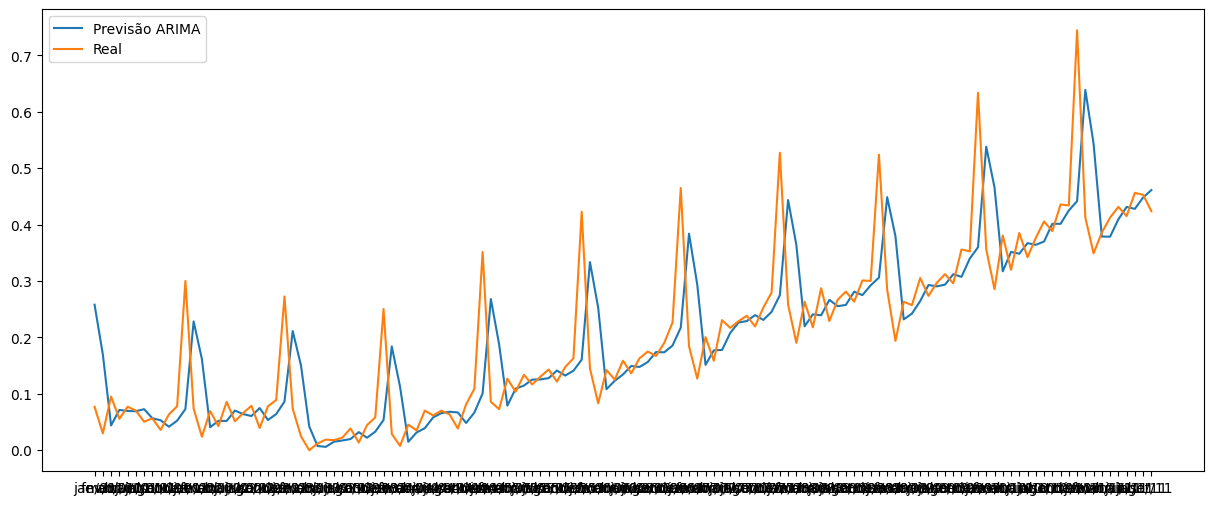

In [110]:
predictions_ARIMA = modelo_ARIMA.predict_in_sample()
plt.plot(predictions_ARIMA[12:], label='Previsão ARIMA')
plt.plot(y_train_varejo_ARIMA[12:], label='Real')
plt.legend()

### Modelo ARMA

In [111]:
modelo_ARMA = pm.arima.ARIMA(order=(1,0,1))
modelo_ARMA.fit(y_train_varejo_ARIMA_diff)

ARIMA(order=(1, 0, 1))

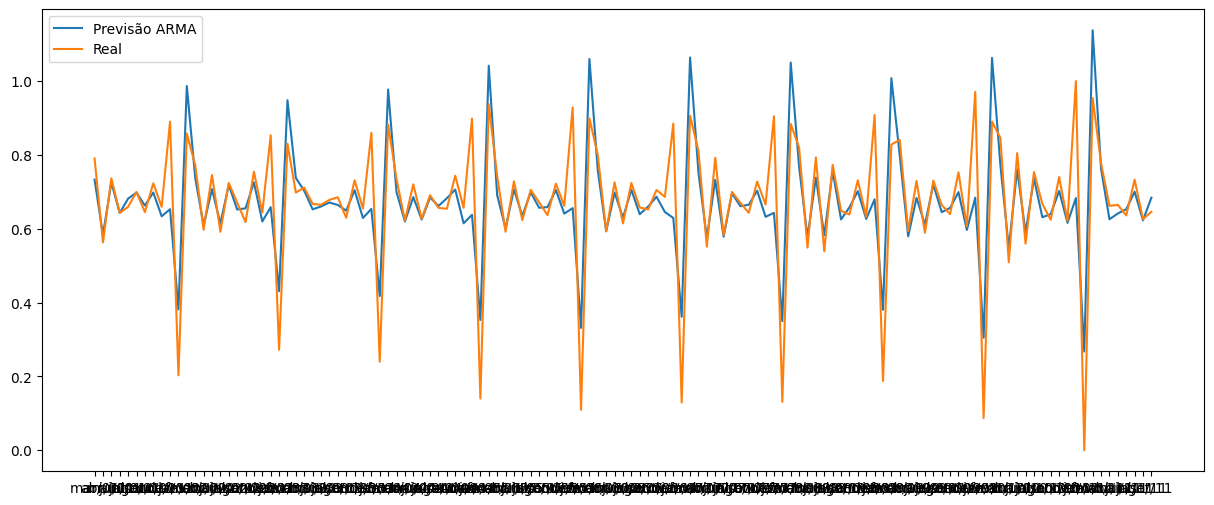

In [112]:
predictions_ARMA = modelo_ARMA.predict_in_sample()
plt.plot(predictions_ARMA[12:], label='Previsão ARMA')
plt.plot(y_train_varejo_ARIMA_diff[12:], label='Real')
plt.legend()

## Teste e comparação dos modelos

Para teste e comparação, será necessário prever os passos seguintes da série com cada modelo e averiguar as métricas MSE e MAPE.

In [113]:
def prever_proximo(model):
    fc = model.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]

In [114]:
def lista_previsoes(y_test, modelo):
  previsoes = []
  for new_ob in y_test:
    fc = prever_proximo(modelo)
    previsoes.append(fc)
    modelo.update(new_ob)
  return previsoes

def avaliar_modelo(y_test, previsoes):
  print("Teste MSE: %.10f" % mse(y_test, previsoes))
  print("Teste MAPE: %.10f" % mape(y_test, previsoes))

### Modelo ARIMA

In [115]:
avaliar_modelo(y_test_varejo_ARIMA, lista_previsoes(y_test_varejo_ARIMA, modelo_ARIMA))

Teste MSE: 0.0211491466
Teste MAPE: 0.1577676181


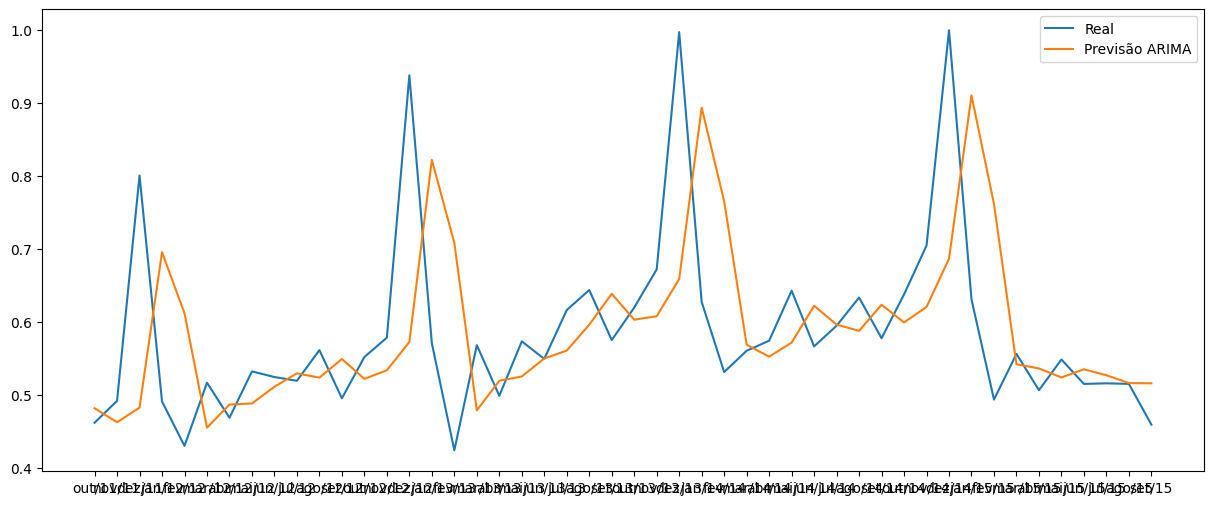

In [116]:
plt.plot(y_test_varejo_ARIMA, label='Real')
plt.plot(lista_previsoes(y_test_varejo_ARIMA, modelo_ARIMA), label='Previsão ARIMA')
plt.legend()

### Modelo ARMA

In [117]:
avaliar_modelo(y_test_varejo_ARIMA_diff, lista_previsoes(y_test_varejo_ARIMA_diff, modelo_ARMA))

Teste MSE: 0.0234123974
Teste MAPE: 0.7797228743


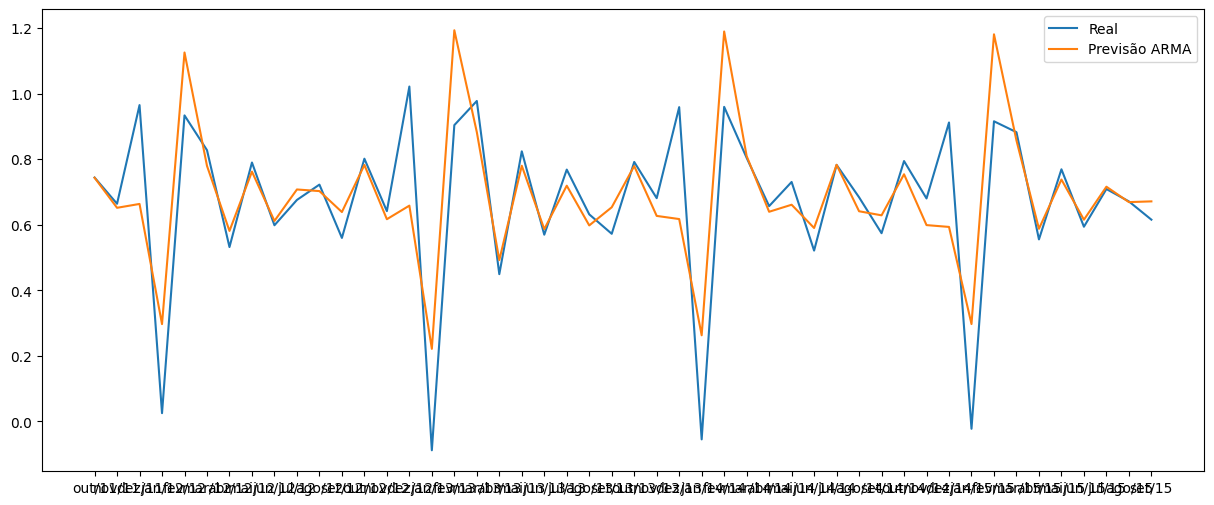

In [118]:
plt.plot(y_test_varejo_ARIMA_diff, label='Real')
plt.plot(lista_previsoes(y_test_varejo_ARIMA_diff, modelo_ARMA), label='Previsão ARMA')
plt.legend()

### ARIMA vs ARMA

O ARMA obteve um MSE levemente menor do que o ARIMA, sugerindo uma taxa de erro melhor, mas o ARIMA obteve um MAPE bastante inferior ao ARMA, e isso sugere um possível equilíbrio entre ambos os modelos. De qualquer maneira, o MAPE de ambos esteve abaixo de 1%, o que é um resultado bastante sólido para previsão de vendas.  
Possivelmente, o ARIMA seria mais útil para prever o comportamento em geral da série, enquanto o ARMA pode ser mais útil para prever altas e baixas.

# Modelo de Aprendizado de Máquina

## Definição de janelas

Para o desenvolvimento de um modelo de aprendizado de máquina é fundamental identificar um número ótimo de lags para gerar as janelas. Para identificá-lo, pode-se observar a autocorrelação da série normalizada.

In [119]:
def gerar_janelas(tam_janela, serie):
  tam_serie = len(serie)
  tam_janela = tam_janela +1
  
  janela = list(serie[0:0+tam_janela])
  janelas_np = np.array(np.transpose(janela))
  
  for i in range(1, tam_serie-tam_janela):
    janela = list(serie[i:i+tam_janela])
    j_np = np.array(np.transpose(janela))
    janelas_np = np.vstack((janelas_np, j_np))
  return janelas_np

In [120]:
def select_lag_acf(serie, max_lag):
  x = serie[0: max_lag+1]

  acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False)

  limiar_superior = confint[:, 1] - acf_x
  limiar_inferior = confint[:, 0] - acf_x

  lags_selecionados = []
  for i in range(1, max_lag+1):
    if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
      lags_selecionados.append(i-1)

  if len(lags_selecionados)==0:
    print('NENHUM LAG POR ACF')
    lags_selecionados = [i for i in range(max_lag)]

  lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
  print('LAGS', lags_selecionados)

  return lags_selecionados

In [121]:
lag_sel = select_lag_acf(varejo.Venda_norm, 20)

LAGS [19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]


### Separação entre treino, teste e validação

A série possui 189 elementos, mas se houver alterações nas janelas, será necessário reajustar as quantidades nos conjuntos de treino, teste e validação para assegurar 50% de elementos de treino e 25% em teste e validação, então a função de divisão utilizará os percentuais.

In [122]:
def train_test_val_split(serie):
  x_date = serie[:, 0:-1]
  y_date = serie[:, -1]        
  
  train_size = np.fix(len(serie)*0.5).astype(int)
  test_size = np.fix(len(serie)*0.25).astype(int)
  val_size = len(serie) - train_size - test_size
  
  x_train = x_date[0:train_size,:]
  y_train = y_date[0:train_size]
  print("Particao de Treinamento:", 0, train_size)
  
  x_test = x_date[train_size:(train_size+test_size),:]
  y_test = y_date[train_size:(train_size+test_size)]
  print("Particao de Teste:", train_size, (train_size+test_size))

  x_val = x_date[(train_size+test_size):-1,:]
  y_val = y_date[(train_size+test_size):-1]
  print("Particao de Validacao:", (train_size+test_size), len(y_date))
  
  return x_train, y_train, x_test, y_test, x_val, y_val

In [123]:
max_janelas = lag_sel[0]
janelas_teste = gerar_janelas(max_janelas, varejo.Venda_norm)
x_train_varejo, y_train_varejo, x_test_varejo, y_test_varejo, x_val_varejo, y_val_varejo = train_test_val_split(janelas_teste)

Particao de Treinamento: 0 84
Particao de Teste: 84 126
Particao de Validacao: 126 169


## Modelo SVR

### Busca pela melhor configuração

In [124]:
def melhor_svr(x_train, y_train, x_test, y_test, execucoes):
  kernels=['linear', 'poly', 'rbf', 'sigmoid']
  gammas=[1, .1, .01, .001]
  epsilons=[.1, .01, .001]
  qtd_lags_sel = len(x_train[0])
  best_result = np.Inf
  for i in range(0,len(kernels)):
    for j in range(0,len(gammas)):
      for z in range(0, len(epsilons)):
        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela
          print('QTD de Lags:', qtd_lag, ' Kernel:' ,kernels[i], ' Gamma:', gammas[j], ' Epsilon:', epsilons[z])
          for k in range(0, execucoes):
            svr = SVR(kernel=kernels[i], gamma=gammas[j], epsilon=epsilons[z])
            svr.fit(x_train[:,-qtd_lag:], y_train)
            predict_validation = svr.predict(x_test[:,-qtd_lag:])
            mse_calc = mse(y_test, predict_validation)
            if mse_calc < best_result:
              best_result = mse_calc
              print('Melhor MSE:', best_result)
              select_model = svr
              qtd_lags_sel = qtd_lag

    return select_model, qtd_lags_sel

In [125]:
modelo_SVR, melhor_lag_SVR = melhor_svr(x_train_varejo, y_train_varejo, x_test_varejo, y_test_varejo, 10)

QTD de Lags: 1  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.0450638147131618
QTD de Lags: 2  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.041596477940080014
QTD de Lags: 3  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.039589476421645564
QTD de Lags: 4  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.030776084603213433
QTD de Lags: 5  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.025942036818987668
QTD de Lags: 6  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.015589128296118087
QTD de Lags: 7  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.012337888148953017
QTD de Lags: 8  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.012153915265899937
QTD de Lags: 9  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.01114737259435353
QTD de Lags: 10  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.011110437140503087
QTD de Lags: 11  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.010503317502560743
QTD de Lags: 12  Kernel: linear  

In [126]:
print('Melhor configuração do SVR:', modelo_SVR)
print('Melhor lag:', melhor_lag_SVR)

Melhor configuração do SVR: SVR(epsilon=0.001, gamma=1, kernel='linear')
Melhor lag: 15


### Previsões

In [127]:
previsoes_svr_treino = modelo_SVR.predict(x_train_varejo[:, -melhor_lag_SVR:])
previsoes_svr_teste = modelo_SVR.predict(x_test_varejo[:, -melhor_lag_SVR:])
previsoes_svr_val = modelo_SVR.predict(x_val_varejo[:, -melhor_lag_SVR:])

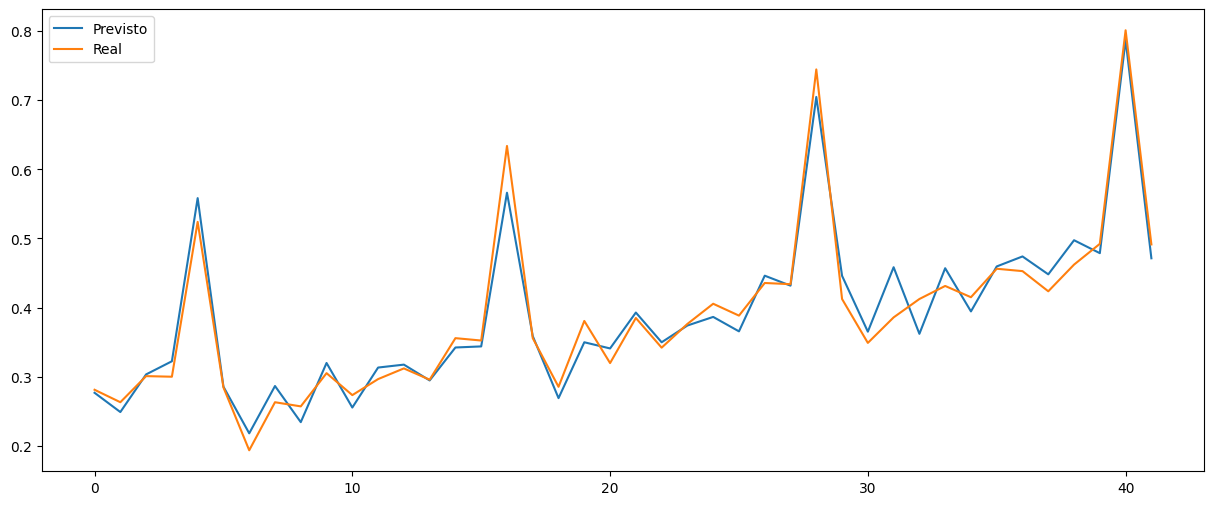

In [128]:
plt.plot(previsoes_svr_teste, label = 'Previsto')
plt.plot(y_test_varejo, label='Real')
plt.legend(loc='best')
plt.show()

In [129]:
print('MSE:', mse(y_test_varejo, previsoes_svr_teste))
print('MAPE:', mape(y_test_varejo, previsoes_svr_teste))

MSE: 0.000642366973889431
MAPE: 0.05133949054793666


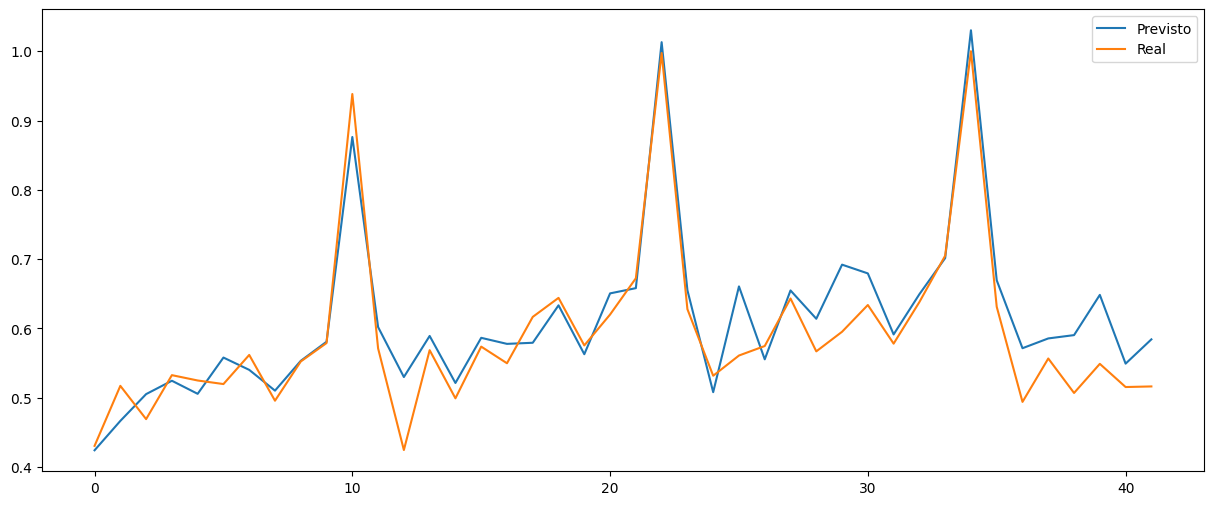

In [130]:
plt.plot(previsoes_svr_val, label = 'Previsto')
plt.plot(y_val_varejo, label='Real')
plt.legend(loc='best')
plt.show()

In [131]:
print('MSE:', mse(y_val_varejo, previsoes_svr_val))
print('MAPE:', mape(y_val_varejo, previsoes_svr_val))

MSE: 0.0020203546892842783
MAPE: 0.06232666006582422


## Modelo MLP

### Busca pela melhor configuração

In [132]:
def melhor_mlp(x_train, y_train, x_test, y_test, execucoes):
  neuronios = [10, 20, 50]
  ativacao = ['logistic', 'relu']
  treinamento = ['lbfgs', 'adam']
  max_iteracoes = [1000, 3000]
  aprendizado = ['constant', 'adaptive']
  qtd_lags_sel = len(x_train[0])
  best_result = np.Inf
  for i in range(0,len(neuronios)):
    for j in range(0,len(ativacao)):
      for k in range(0, len(treinamento)):
        for l in range(0, len(max_iteracoes)):
          for m in range (0, len(aprendizado)):
            for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela
              print('QTD de Lags:', qtd_lag, ' Neurônios:', neuronios[i], ' Função de ativação:', ativacao[j], 
                    ' Treinamento:', treinamento[k], ' Iterações máximas:', max_iteracoes[l], 
                    ' Modelo de aprendizado:', aprendizado[m])
              
              for execucao in range(0, execucoes):
                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=ativacao[j], solver=treinamento[k], max_iter=max_iteracoes[l], learning_rate=aprendizado[m])
                mlp.fit(x_train[:,-qtd_lag:], y_train)
                predict_validation = mlp.predict(x_test[:,-qtd_lag:])
                mse_calc = mse(y_test, predict_validation)
                if mse_calc < best_result:
                  best_result = mse_calc
                  print('Melhor MSE:', best_result)
                  select_model = mlp
                  qtd_lags_sel = qtd_lag

  return select_model, qtd_lags_sel

In [133]:
modelo_MLP, melhor_lag_MLP = melhor_mlp(x_train_varejo, y_train_varejo, x_test_varejo, y_test_varejo, 10)

QTD de Lags: 1  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.026546182706272424
Melhor MSE: 0.026469320552436396
Melhor MSE: 0.026459748919287363
Melhor MSE: 0.026258575018942413
QTD de Lags: 2  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.021660189061887214
QTD de Lags: 3  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.0196468641284187
Melhor MSE: 0.019503770798202952
Melhor MSE: 0.018432229329640004
Melhor MSE: 0.018345202763451827
Melhor MSE: 0.018333654628287295
QTD de Lags: 4  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.017963751856796113
Melhor MSE: 0.01653259793141198
Melhor MSE: 0.01587196465430796
QTD de Lags: 5  Neurôni

In [134]:
print('Melhor configuração do MLP:', modelo_MLP)
print('Melhor lag:', melhor_lag_MLP)

Melhor configuração do MLP: MLPRegressor(hidden_layer_sizes=10, max_iter=3000, solver='lbfgs')
Melhor lag: 14


### Previsões

In [135]:
previsoes_mlp_treino = modelo_MLP.predict(x_train_varejo[:, -melhor_lag_MLP:])
previsoes_mlp_teste = modelo_MLP.predict(x_test_varejo[:, -melhor_lag_MLP:])
previsoes_mlp_val = modelo_MLP.predict(x_val_varejo[:, -melhor_lag_MLP:])

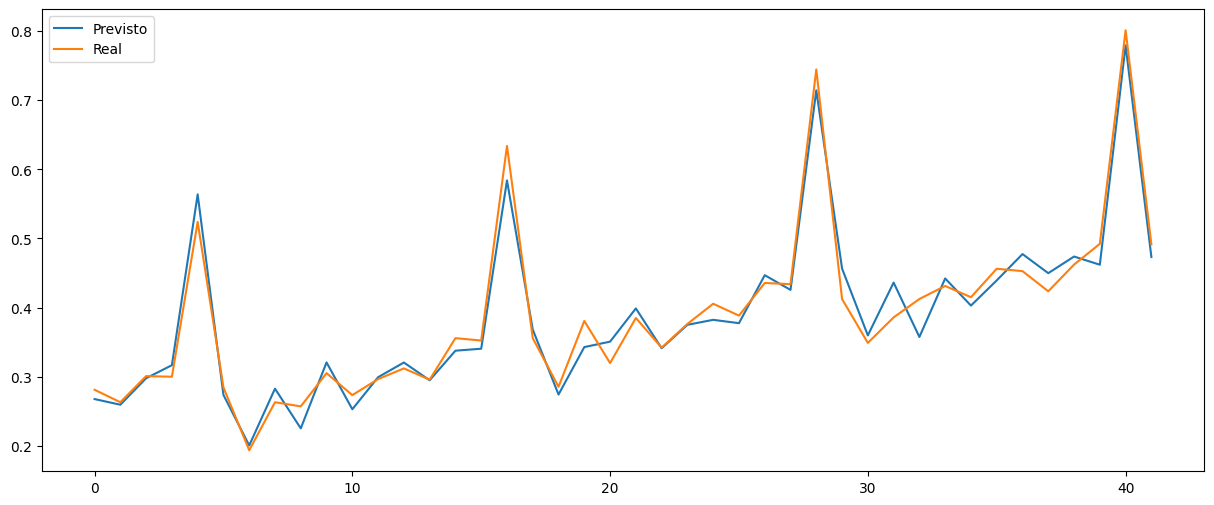

In [136]:
plt.plot(previsoes_mlp_teste, label = 'Previsto')
plt.plot(y_test_varejo, label='Real')
plt.legend(loc='best')
plt.show()

In [137]:
print('MSE:', mse(y_test_varejo, previsoes_mlp_teste))
print('MAPE:', mape(y_test_varejo, previsoes_mlp_teste))

MSE: 0.0005532291616678237
MAPE: 0.04870808553420938


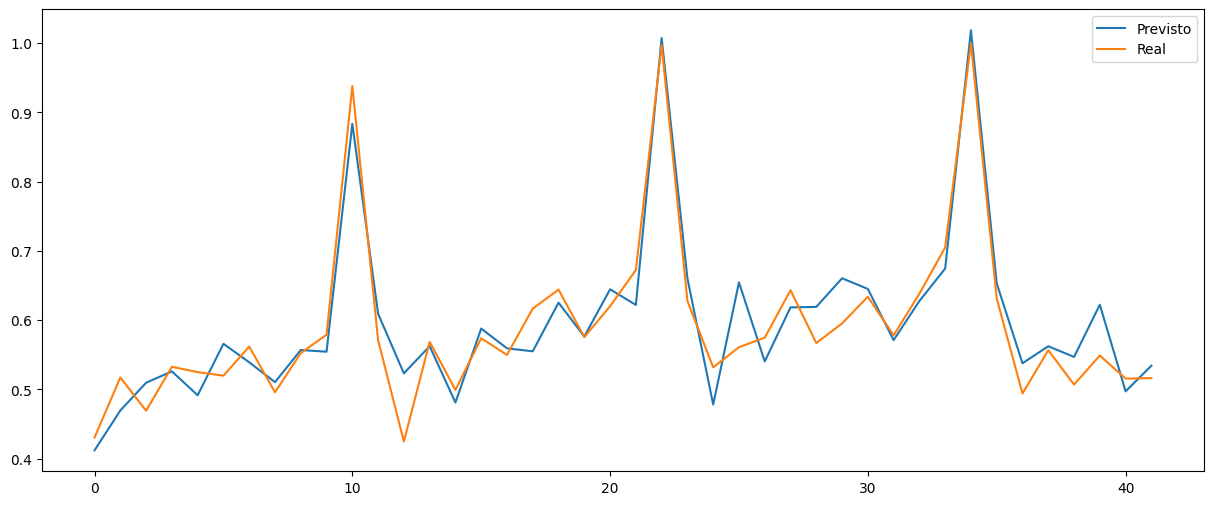

In [138]:
plt.plot(previsoes_mlp_val, label = 'Previsto')
plt.plot(y_val_varejo, label='Real')
plt.legend(loc='best')
plt.show()

In [139]:
print('MSE:', mse(y_val_varejo, previsoes_mlp_val))
print('MAPE:', mape(y_val_varejo, previsoes_mlp_val))

MSE: 0.001528223834446675
MAPE: 0.05600480023511662


# Modelo Híbrido

Pode-se criar um modelo híbrido simples somando os resultados da previsão da série temporal feita pelo ARIMA com uma previsão dos erros do ARIMA feita por um modelo de aprendizado de máquina. Para isso, será necessário fazer um DataFrame com as janelas temporais cujo target é o resíduo do ARIMA ao invés do valor real.

## Resíduos do ARIMA

O modelo híbrido depende dos resíduos das previsões do ARIMA, então antes de tudo é necessário extrair esses resíduos.

In [140]:
modelo_ARIMA_H = pm.arima.ARIMA(order=(1,2,1))
modelo_ARIMA_H.fit(y_train_varejo)

ARIMA(order=(1, 2, 1))

In [141]:
previsoes_ARIMA_H_treino = lista_previsoes(y_train_varejo, modelo_ARIMA_H)
residuos_treino = [y_train_varejo[i] - previsoes_ARIMA_H_treino[i] for i in range(0, len(previsoes_ARIMA_H_treino))]

residuos_treino

[-0.20132278744125381,
 -0.09421809000382053,
 0.028600337103559262,
 0.0326409617671388,
 0.2349163891301485,
 -0.1469827345425126,
 -0.1305835434914644,
 0.03556825155775284,
 -0.002574823109462304,
 0.040781470830901445,
 -0.013306950357509034,
 0.008939791918389492,
 0.02443047837230458,
 -0.028463237204253783,
 0.032326240860164966,
 0.029913048627873785,
 0.1941419285838999,
 -0.13482527454855298,
 -0.11927949628886464,
 -0.03582447570642459,
 0.01174317414841134,
 0.019335945774934495,
 0.010411000749975599,
 0.011027355758780947,
 0.025699412213585505,
 -0.013880352917023952,
 0.0277398162135386,
 0.03198253099239036,
 0.20090343602472843,
 -0.1531968576076031,
 -0.09905330248987215,
 0.03667916095787074,
 0.009394878147639361,
 0.03687604448808143,
 0.008328881330607905,
 0.009793715650466911,
 0.0006924462552404809,
 -0.022476355819798684,
 0.040220977537173117,
 0.04676502781910381,
 0.2548295781057959,
 -0.18183534764421294,
 -0.11175338226640663,
 0.0520823766008911,
 -0.0

In [142]:
print(len(residuos_treino))
print(len(x_train_varejo))

84
84


In [143]:
previsoes_ARIMA_H_teste = lista_previsoes(y_test_varejo, modelo_ARIMA_H)
residuos_teste = [y_test_varejo[i] - previsoes_ARIMA_H_teste[i] for i in range(0, len(previsoes_ARIMA_H_teste))]

residuos_teste

[0.026119676279023174,
 -0.015489273579121998,
 0.028481344017970478,
 0.00984634868740647,
 0.22012779376140162,
 -0.16650775711062515,
 -0.183676009473543,
 0.03459430072120656,
 0.017716196991531125,
 0.04417749817309724,
 -0.017272021150523398,
 0.00896459983706227,
 0.021157743019770026,
 -0.013629815292600655,
 0.051220059251378514,
 0.014476837320888059,
 0.27595997344555584,
 -0.1859793883427548,
 -0.17991043337856638,
 0.06563665377463102,
 -0.030345584379955548,
 0.039449633515213856,
 -0.023177114812985067,
 0.014794425428145186,
 0.0376388292956098,
 -0.01152452627695999,
 0.03603564004944554,
 0.01023588449910423,
 0.304281787557647,
 -0.2310401561853665,
 -0.19401330562407343,
 0.008665779022055065,
 0.0362621757864422,
 0.02437454978346526,
 -0.014190152737565409,
 0.03052150583359864,
 0.005780150453028432,
 -0.036076721037121895,
 0.02341622456246062,
 0.038685381695461096,
 0.3139405113065803,
 -0.20943977577407807]

In [144]:
len(residuos_teste)

42

In [145]:
previsoes_ARIMA_H_val = lista_previsoes(y_val_varejo, modelo_ARIMA_H)
residuos_val = [y_val_varejo[i] - previsoes_ARIMA_H_val[i] for i in range(0, len(previsoes_ARIMA_H_val))]

residuos_val

[-0.18402002477853202,
 0.05832913593227418,
 -0.02249910482304268,
 0.04038368284414079,
 0.009432189603688856,
 -0.014227410908410287,
 0.033920073235203074,
 -0.057574836078043645,
 0.026965578510116606,
 0.04106736043986037,
 0.36152481980876694,
 -0.2500010645476095,
 -0.29111008173200387,
 0.08436950250383835,
 -0.022529028716991528,
 0.04384095697661228,
 0.0003179972634239636,
 0.052078237071062516,
 0.04511162709224226,
 -0.0662414383641724,
 0.012651076155586694,
 0.061527663972895885,
 0.3362060672841177,
 -0.26507826106527244,
 -0.2413500222077185,
 -0.012729522488622469,
 0.01904170787331594,
 0.0681982522202843,
 -0.057681062222174395,
 -0.005471575716530563,
 0.04305853411536642,
 -0.04774851773664246,
 0.033863515110941766,
 0.08272724717704538,
 0.3118436685959137,
 -0.27380783874081915,
 -0.28041272874245665,
 0.007671118216191042,
 -0.03100737306207557,
 0.020307219727359604,
 -0.021832389904165472,
 -0.014933334153096056]

In [146]:
len(residuos_val)

42

Uma vez que os resíduos estão separados em séries isoladas, pode-se enfim treinar novamente os modelos utilizando-as como alvos no lugar das séries y.

## Modelos de aprendizado de máquina

### Modelo SVR

In [147]:
modelo_SVR_H, melhor_lag_SVR_H = melhor_svr(x_train_varejo, residuos_treino, x_test_varejo, residuos_teste, 10)

QTD de Lags: 1  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.02071303834412153
QTD de Lags: 2  Kernel: linear  Gamma: 1  Epsilon: 0.1
QTD de Lags: 3  Kernel: linear  Gamma: 1  Epsilon: 0.1
QTD de Lags: 4  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.017774329740212483
QTD de Lags: 5  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.013953635573456672
QTD de Lags: 6  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.013619045000527664
QTD de Lags: 7  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.011384411372318808
QTD de Lags: 8  Kernel: linear  Gamma: 1  Epsilon: 0.1
QTD de Lags: 9  Kernel: linear  Gamma: 1  Epsilon: 0.1
QTD de Lags: 10  Kernel: linear  Gamma: 1  Epsilon: 0.1
QTD de Lags: 11  Kernel: linear  Gamma: 1  Epsilon: 0.1
QTD de Lags: 12  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.004263035023347035
QTD de Lags: 13  Kernel: linear  Gamma: 1  Epsilon: 0.1
Melhor MSE: 0.004185957149176006
QTD de Lags: 14  Kernel: linear  Gamma: 1  Epsilon:

In [149]:
previsoes_svr_H_teste = modelo_SVR_H.predict(x_test_varejo[:, -melhor_lag_SVR_H:])
previsoes_svr_H_val = modelo_SVR_H.predict(x_val_varejo[:, -melhor_lag_SVR_H:])

In [150]:
print('MSE:', mse(residuos_teste, previsoes_svr_H_teste))
print('MAPE:', mape(residuos_teste, previsoes_svr_H_teste))

MSE: 0.0006337604835388841
MAPE: 0.7818881758149357


In [151]:
print('MSE:', mse(residuos_val, previsoes_svr_H_val))
print('MAPE:', mape(residuos_val, previsoes_svr_H_val))

MSE: 0.001523492613501822
MAPE: 1.5861637275529388


### Modelo MLP

In [165]:
modelo_MLP_H, melhor_lag_MLP_H = melhor_mlp(x_train_varejo, residuos_treino, x_test_varejo, residuos_teste, 10)

QTD de Lags: 1  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.01838027257752809
Melhor MSE: 0.018060460354815705
QTD de Lags: 2  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
QTD de Lags: 3  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
QTD de Lags: 4  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.016218328113801573
Melhor MSE: 0.016086614704356017
Melhor MSE: 0.016063675114489726
Melhor MSE: 0.01559836897085815
QTD de Lags: 5  Neurônios: 10  Função de ativação: logistic  Treinamento: lbfgs  Iterações máximas: 1000  Modelo de aprendizado: constant
Melhor MSE: 0.01384035160084587
Melhor MSE: 0.01383430712503856
Melhor MSE: 0.01372999172659365
QTD de Lags: 6  Ne

In [166]:
previsoes_mlp_H_teste = modelo_MLP_H.predict(x_test_varejo[:, -melhor_lag_MLP_H:])
previsoes_mlp_H_val = modelo_MLP_H.predict(x_val_varejo[:, -melhor_lag_MLP_H:])

In [167]:
print('MSE:', mse(residuos_teste, previsoes_mlp_H_teste))
print('MAPE:', mape(residuos_teste, previsoes_mlp_H_teste))

MSE: 0.0006652075154213943
MAPE: 0.7968495729427341


In [168]:
print('MSE:', mse(residuos_val, previsoes_mlp_H_val))
print('MAPE:', mape(residuos_val, previsoes_mlp_H_val))

MSE: 0.0019783402198293647
MAPE: 1.6572534869424698


## Soma de previsões de valores e de resíduos

### Modelo SVR

In [162]:
soma_ARIMA_SVR_teste = [previsoes_ARIMA_H_teste[i] + previsoes_svr_H_teste[i] for i in range(0,len(previsoes_ARIMA_H_teste))]
print('MSE:', mse(y_test_varejo, soma_ARIMA_SVR_teste))
print('MAPE:', mape(y_test_varejo, soma_ARIMA_SVR_teste))

MSE: 0.0006337604835388841
MAPE: 0.051587793253321586


In [164]:
soma_ARIMA_SVR_val = [(previsoes_ARIMA_H_val[i] + previsoes_svr_H_val[i]) for i in range(0,len(previsoes_ARIMA_H_val))]
print('MSE:', mse(y_val_varejo, soma_ARIMA_SVR_val))
print('MAPE:', mape(y_val_varejo, soma_ARIMA_SVR_val))

MSE: 0.001523492613501822
MAPE: 0.05382844218172918


### Modelo MLP

In [169]:
soma_ARIMA_MLP_teste = [previsoes_ARIMA_H_teste[i] + previsoes_mlp_H_teste[i] for i in range(0,len(previsoes_ARIMA_H_teste))]
print('MSE:', mse(y_test_varejo, soma_ARIMA_MLP_teste))
print('MAPE:', mape(y_test_varejo, soma_ARIMA_MLP_teste))

MSE: 0.0006652075154213943
MAPE: 0.056131321312459535


In [170]:
soma_ARIMA_MLP_val = [previsoes_ARIMA_H_val[i] + previsoes_mlp_H_val[i] for i in range(0,len(previsoes_ARIMA_H_val))]
print('MSE:', mse(y_test_varejo, soma_ARIMA_MLP_val))
print('MAPE:', mape(y_test_varejo, soma_ARIMA_MLP_val))

MSE: 0.0752449160385852
MAPE: 0.7027877334309205


Método de combinação não-linear  
Prever com ARIMA, subtrair resultados dos valores reais, usar resíduos como target do modelo SVR, criar coluna no DataFrame do SVR com soma da previsão do ARIMA com previsão de resíduos do modelo SVR, usar modelo alternativo no novo DataFrame.